## Loss functions

**TODO** 
Add Intro about loss function

....


We evalute models build with ML and NN methods by computing the error or loss incured by model predictions. 
Recall one of the most common loss functions - mean squared error. 


.....


## Mean Squared Error Loss


Let's re-cap how to compute Mean Squared Error Loss (MSE) for linear predictor `y_pred = w*x`. 
The MSE loss defined as an average of squared differences between true labels and predictions:

`Loss = np.mean(np.square(y - y_pred))`


where:

`x` - feature vector\
`w` - weight\
`y` - label vector \
`y_pred` - predictions 

Below there is a plot of MSE loss function as a function of a weight. This means, that `x` and `y` are "fixed" and only weight values are changing. The shape of the MSE loss function is parabola with one minimum point (which is also a [global minimum](https://en.wikipedia.org/wiki/Maxima_and_minima#/media/File:Extrema_example_original.svg) in this case) and this minimum is corresponding to the lowest MSE loss value. 

You can see that some weights will give a bigger MSE loss (black dot on the left plot) and weights near  global minimum of the function will give a small MSE loss (red dot). Not suprizingly, the predictions made with weights giving a small MSE loss fit better the data (linear predictor plotted as a red line on the right plot) than predictions made with weights giving a large MSE loss (black line).

<img src="../../Material-for-MLpython-course/GD_MSE/MSE.png" alt="Drawing" style="width: 700px;"/>

## Gradient descent 

So, how can we find the optimal weight, which gives us a smallest MSE loss possible? \
One way is to use derivative of the function. Breifly, [derivative](https://en.wikipedia.org/wiki/Derivative) describes the rate of change of a function respectively to change of its arument.  

The derivative of the MSE loss function with respect to (w.r.t.) weight will tell us how the function is changing when changing the weight value. In the case if we have more parameters of the loss function (more than one weight) we will need to compute not a derivative, but [gradient](https://en.wikipedia.org/wiki/Gradient) - a vector, which elements are the partial derivatives of loss function.

The algorithm, which uses gradient to find a minimum of the loss function is called **gradient descent**. Gradient descent is an iterative algorithm. During each iteration the algorithm estimates how the parameters (weights) of the function should be changed in order to reach the local minimum of the function. More precisely, the gradient of the function is calculated and algorithm "takes" small steps in the direction of the steepest descent of the function. Common analogy for this algorithm is taking a path downhill in the mountains [read here](https://en.wikipedia.org/wiki/Gradient_descent).

**Gradient descent algorithm includes following steps:**

**1. initialize weights randomly**\
**2. compute predictions, given current weights**\
**3. compute loss (e.g. MSE loss)**\
**4. compute gradient of the loss function**\
**5. update the weights - change the weights values to the opposite direction from gradient** `weight = weight - step*gradient`


The algorithm is then repeated pre-defined amount of times (iterations). The `step` parameter or **learning rate** regulates how large the change of weight value will be. If the step size is too small, the algorithm may take too much time to find a minimum (or, in computer science terminology, it will take too much time to converge). If the step size is too big, it is possible that algorithms will move to totally opposite direction from the minimum (or algorithm will diverge).

Above we discussed very simple case with dataset having only one feature and weight and MSE as a loss function. In reality, the dataset may have thousands of parameters (weights) and model may be evaluated by more complicated loss function than MSE.

Below you can see examples of loss function landscapes of more complicated models (neural networks), which illustrates that finding a minimum of these loss functions is not a trivial task:

<img src="../../Material-for-MLpython-course/GD_MSE/NNloss.png" alt="Drawing" style="width: 500px;"/>


<center><a href="https://www.cs.umd.edu/~tomg/projects/landscapes/">image source</a></center>
<center><a href="https://arxiv.org/abs/1712.09913/">original paper</a></center>

Here some entertaining examples of neural network loss function visualizations:

[3D visualization of NN loss functions](http://www.telesens.co/loss-landscape-viz/viewer.html) \
[3D animation of NN loss functions](https://www.youtube.com/watch?time_continue=32&v=aq3oA6jSGro&feature=emb_logo)


## Stochastic gradient descent 

While we discussed the main steps of the gradient descent algorithm above, in practice the slight variation of the algorith called **mini-batch  stochastic gradient descent** is more common. The idea is to divide the dataset into random subsets or **batches** and perform the gradient descent algorithm on each batch. When the algorithm pass through all batches, or through ENTIRE dataset, we say that algorithm ran for one **epoch**. 

We can therefore classify the gradient descent algorithms, based on the **batch size** (number of samples per batch):

- Batch gradient descent (batch size = whole dataset)
- Mini-batch stochastic gradient descent (1 < batch size < whole dataset)
- "True" stochastic gradient descent (batch size = 1)

The pros of using batches instead of the entire dataset is that it is computationally easier, therefore faster and cons - it requires more learning time (more epoches to run). 

Many machine learning and deep learning Python libraries, such as sklearn and keras, provide ready-to-use gradient based algorithms. Nevertheless, let's implement our own simplified mini-batch stochastic gradient descent (or mini-batch SGD) algorithm for learning purposes. In this simple case we have 100 data points (samples) which are described by only one feature `X` and have labels stored in `y`. \
We need to find the optimal linear predictor `y_pred = weight*X`.

First, we need to import all needed Python libraries.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression 

Next, we will generate some dataset by using sklearn.dataset `make_regression` function.

In [11]:
# generate dataset for regression problem

X, y = make_regression(n_samples=100, n_features=1, noise=20, random_state=2) 
X = X.reshape(-1,)
X = preprocessing.scale(X)

We used sklearn `preprocessing` module ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html#sklearn-preprocessing-scale)) to scale our features `X`. Learn [here](https://www.youtube.com/watch?v=r5E2X1JdHAU&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN&index=20), why it is usefull to normalize the data when applying the gradient descent algorithm. 

Before implementing the SGD algorithm, we need to write a helper function `batch()` to divide our dataset and corresponding labels into batches. We will provide the feature matrix `X` and label vector `y` as an input to the function. We also need to define the parameter `batch_size` or number of data points in each batch. The function `batch()` is a Python generator function, meaning that the function can be used in for-loops and will return batches sequentially, one-by-one. Before splitting the dataset into batches, we will randomly shuffle the data, so every time we call `batch()` we will generate batches from dataset, where data points are in a random order.

In [12]:
def batch(X,y,batch_size):
    
    '''
    
    This is a function for creating minibatches of the dataset.
    The yield statement suspends function’s execution and sends 
    a value back to the caller, but retains enough state to enable 
    function to resume where it is left off. 
    
    '''
    # check if the number of datapoints is equal in feature matrix X and label vector y
    # if assertion fails return error message "Number of datapoints are different in X and y"
    assert X.shape[0] == y.shape[0], "Number of datapoints are different in X and y"
    
    # shuffle datapoints 
    # premutation will randomly re-arrange the order of the numbers
    # which will be used as indices to create X and y with datapoints in different order
    p = np.random.permutation(len(y))
    X_perm = X[p] 
    y_perm = y[p]
    
    # generate batches
    for i in range(0,X.shape[0],batch_size):
        yield (X_perm[i:i + batch_size], y_perm[i:i + batch_size])

Now we are ready to implement gradient descent algorithm. It will be implemented in a `grad_descent()` function, where feature matrix `X`, label vector `y`,  initial weights and a learning rate is provided as an input to the function.
Therefore, the function `grad_descent()` will:

1. compute predictions, given the current weights
2. compute MSE loss 
3. compute gradient of the loss function
4. update the weights - change the weights values to the opposite direction from gradient `weight = weight - step*gradient`



In [13]:
def grad_descent(X,y,weight,lrate):
    
    '''
    
    This is a function for performing palin gradient descent algorithm with MSE loss function.

    squared error loss for a single datapoint:        
      loss = (y - weight*x)**2
    derivative w.r.t. to weight for a single datapoint:  
      der_w = -2x*(y - weight*x)
      
    To compute the MSE and derivative of MSE - take an averge of all datapoints.
    
    '''
    
    # performing Gradient Descent:
    
    # 1. compute predictions, given the weight
    y_hat = weight*X   
    # 2. compute MSE loss
    MSE = np.mean((y - y_hat)**2)
    # 3. compute gradient of loss function
    der_w = -2*np.mean(X*(y - y_hat))  
    # 4. update the weights
    weight = weight - lrate* der_w            
 
    return weight, MSE 

Finally, we combine all elements in `minibatchSGD()` function. The parameters of the function: \
`X` - features \
`y` - labels   \
`batch_size` - number of samples per batch \
`epoches` - how many times to iterate through the ENTIRE dataset \
`lrate` - step size or learning rate of gradient descent

The function will return learnt weight after running the algorithm through entire dataset epoches times.
In addition, the function will return list `loss` where the MSE loss values for all batches and epoches are stored.

In [14]:
def minibatchSGD(X,y,batch_size,epochs,lrate):  
    
    # initialize weight randomly
    weight = np.random.rand()    
    # create list to store the loss values 
    loss = []
     
    for i in range(epochs):
        # run gradient descent for each batch
        for X_batch,y_batch in batch(X,y,batch_size):
            weight, MSE = grad_descent(X_batch,y_batch,weight,lrate)
            # store MSE loss of each batch of each epoch
            loss.append(MSE)
            
        # one epoch is finished when the algorithm goes through ALL batches
    return weight, loss

Let's test our SGD implementation and run the algorithm for:

- batch sizes = 1 (one data point) **("true" SGD)**
- batch sizes = 10 **(mini-batch SGD)**
- batch sizes = 100 (entire dataset) **(Batch GD)**

In [15]:
# set epoches and learning rate
epochs = 200
lrate = 0.1

# batch size 1
model1 = minibatchSGD(X,y,1,epochs,lrate)
# batch size 10
model2 = minibatchSGD(X,y,10,epochs,lrate)
# batch size 100
model3 = minibatchSGD(X,y,100,epochs,lrate)

The function `minibatchSGD()` returns weight and loss incurred during the training. Let's retrive the loss values for plotting and print out learnt weights.

In [16]:
# history of the MSE loss inccured during learning
batch_loss1 = model1[-1]
batch_loss2 = model2[-1]
batch_loss3 = model3[-1]

# let's check that length of list `loss` is equal to
# X.shape[0]/batch_size*epochs
print("Epochs: ", epochs)
print("Iterations per epoch: {:.0f}, {:.0f}, {:.0f},".format(X.shape[0]/1, X.shape[0]/10, X.shape[0]/100))
print("Total number of iterations: ",len(batch_loss1), len(batch_loss2), len(batch_loss3))

# display weight learnt during the SGD
print("\nWeights: \n\nmodel1 {:.2f} \nmodel2 {:.2f} \nmodel3 {:.2f}".format(model1[0], model2[0], model3[0]))

Epochs:  200
Iterations per epoch: 100, 10, 1,
Total number of iterations:  20000 2000 200

Weights: 

model1 67.57 
model2 59.38 
model3 60.27


We can compare the optimal weights learnt by our algorithm and the optimal weight calculated by sklearn `LinearRegression()` class. This class does not use iterative gradient-based algorithms, but rather calculating opimal weight analytically [learn more here](https://www.youtube.com/watch?v=B-Ks01zR4HY).


In [17]:
# create linear regression model 
reg = LinearRegression(fit_intercept=False) 
# fit a linear regression model 
reg = reg.fit(X.reshape(-1,1), y)
# print optimal coefficients
reg.coef_[0]

60.27113167581484

We can see that our algorithm worked relatevily well, especially when the batch size is equal to the whole dataset. This is due to gradient being more accurate and representative of dataset when we use more datapoints. \
It is usefull to plot the loss values incurred during the training or learning. Let's plot loss values for first 100 iterations (for first 100 batches).

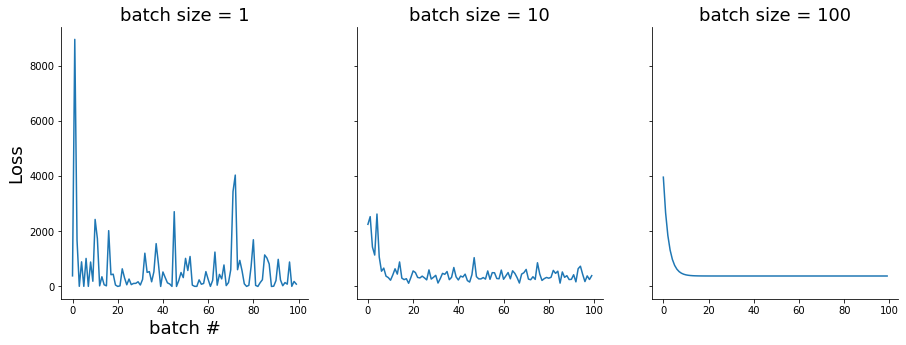

In [18]:
fig, axes = plt.subplots(1,3, sharey=True, figsize=(15,5))

batch_loss_list = [batch_loss1, batch_loss2, batch_loss3]
size_list       = [1,10,100] # batch size


for ax, batch_loss, size in zip(axes, batch_loss_list, size_list):
    ax.plot(np.arange(len(batch_loss[:100])), batch_loss[:100])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_title("batch size = "+str(size), fontsize=18)
    
axes[0].set_xlabel('batch #', fontsize=18)
axes[0].set_ylabel('Loss', fontsize=18)


plt.show()

We can see that when the batch size is small the value of the loss is not decreasing smoothly, but oscillating up and down a lot. This happens because we update our weight based on the gradient computed for only one datapoint and the gradient of a single data point not necesseraly will correspond to the average gradient for all datapoints.

Below are the animations illustrating the training process with SGD where batch size is all data points (upper panel) and where batch size is 10 data points (lower panel, the current batch marked with red color). In line with loss plots we created above, mini-batch SGD is more noisy than batch GD. Although, it seems that using plain batch GD is faster way to reach the minimum of the loss function, in practice when working with large datasets and thousands parameters (weights) in neural networks, this approach will be slower and more computationally expensive than mini-batch SGD.

Batch size = all datapoints (100)
![SegmentLocal](../../Material-for-MLpython-course/GD_MSE/minibatchGD1.gif "segment")
Batch size = 10% of total number of datapoints (10)
![SegmentLocal](../../Material-for-MLpython-course/GD_MSE/minibatchGD2_2.gif "segment")

# Other gardient based optimization methods

In addition to plain GD or SGD, there are many other gradient-based algorithms or optimizers ([list of optimizers implemented in deep learning Python library Keras](https://keras.io/api/optimizers/)). One of the most most known are SGD with momentum, RMSprop and Adam. These are variations of SGD, which are in many cases faster and more robust than mini-batch SGD. \
These algorithms are closely related but may behave quite differently depending on the loss function and hyperparameters settings. You can see it from the animation below, where these optimizers are trying to find the minimum of the [six-hump camel](https://www.sfu.ca/~ssurjano/camel6.html) function. 

![SegmentLocal](../../Material-for-MLpython-course/GD_MSE/camel3D.gif "segment")

## Other resources 

**derivatives:**

- https://www.mathsisfun.com/calculus/derivatives-introduction.html
- (chapters 3-4) https://openstax.org/books/calculus-volume-1/pages/3-1-defining-the-derivative#27277

**gradient descent algorithm:**

Video 
- Andrew Ng, https://www.youtube.com/watch?v=F6GSRDoB-Cg 
- StatQuest, https://www.youtube.com/watch?v=sDv4f4s2SB8
- 3Blue1Brown, https://www.youtube.com/watch?v=IHZwWFHWa-w

Books

- (beginner level) Deep Learning with Python (chapter 2.4) https://livebook.manning.com/book/deep-learning-with-python/chapter-2/193
- (intermediate) Machine Learning: Basic Principles (chapter 5) https://arxiv.org/pdf/1805.05052.pdf
- (advanced) Deep Learning Book https://www.deeplearningbook.org/contents/optimization.html